# GRIB2 NWP Archive aggretation using .idx files

Work with NODD GFS data on GCP (theoretically works with AWS as well)

1) Demonstrate building a DataTree, Index File mapping and Static Metdata data file. Use the mapping to rapidly build a on month dataset.
2) Demonstrate using zarr chunk_getitems hack to parallelize getting a timeseries
   

## Import some stuff...

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import importlib

importlib.reload(logging)
logging.basicConfig(
    format="%(asctime)s.%(msecs)03dZ %(processName)s %(threadName)s %(levelname)s:%(name)s:%(message)s",
    datefmt="%Y-%m-%dT%H:%M:%S",
    level=logging.WARNING,
)

logger = logging.getLogger("juypter")

In [22]:
import datetime
import copy
import xarray as xr
import numpy as np
import pandas as pd
import fsspec
import kerchunk
from kerchunk.grib2 import (
    grib_tree, scan_grib, extract_datatree_chunk_index, strip_datavar_chunks, 
    reinflate_grib_store, AggregationType, read_store, write_store, parse_grib_idx,
    build_idx_grib_mapping, map_from_index
)
import gcsfs
import datatree

pd.set_option('display.max_columns', None)


## Extract the zarr store metadata


Pick a file, any file... Must be on GCS so that coords use the same file store as the data vars

In [8]:
# Pick two files to build a grib_tree with the correct dimensions
gfs_files = [
    "gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f000",
    "gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f001"
]

# This operation reads two of the large Grib2 files from GCS
# scan_grib extracts the zarr kerchunk metadata for each individual grib message
# grib_tree builds a zarr/xarray compatible hierarchical view of the dataset
gfs_grib_tree_store = grib_tree([group for f in gfs_files for group in scan_grib(f)])
# it is slow even in parallel because it requires a huge amount of IO


2024-10-27T21:23:40.133Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 586. Compare with the grib idx file to help identify it and build an ecCodes local grib definitions file to fix it.
2024-10-27T21:23:40.155Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 665. Compare with the grib idx file to help identify it and build an ecCodes local grib definitions file to fix it.
2024-10-27T21:23:40.245Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 1274. Compare with the grib idx file to help identify it and build an ecCodes local grib definitions file to fix it.
2024-10-27T21:23:40.247Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 1285. Compare with the grib idx file to help identify it and build an ecCodes local grib definitions file to fix it.
2024-10-27T21:23:40.263Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 1407. Compare 

In [9]:
# The grib_tree can be opened directly using either zarr or xarray datatree
# But this is too slow to build big aggregations
gfs_dt = datatree.open_datatree(fsspec.filesystem("reference", fo=gfs_grib_tree_store).get_mapper(""), engine="zarr", consolidated=False)
gfs_dt


DataTree('None', parent=None)
├── DataTree('SUNSD')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Sunshine Duration
│   └── DataTree('instant')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  instant
│       └── DataTree('surface')
│               Dimensions:     (time: 1, step: 2, latitude: 721, longitude: 1440)
│               Coordinates:
│                 * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
│                 * step        (step) timedelta64[ns] 16B 00:00:00 01:00:00
│                   surface     float64 8B ...
│                 * time        (time) datetime64[ns] 8B 2023-09-28
│                   valid_time  (time, step) datetime64[ns] 16B ...
│               Data variables:
│                   SUNSD       (time, step, latitude, longitude) float64 17MB ...
│               Attributes:
│                   typeOfLevel:  surface
├── DataTree('VRATE')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Ventilation Rate
│   └── DataTree('instant')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  instant
│       └── DataTree('planetaryBoundaryLayer')
│               Dimensions:                 (time: 1, step: 2, latitude: 721, longitude: 1440)
│               Coordinates:
│                 * latitude                (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
│                 * longitude               (longitude) float64 12kB 0.0 0.25 ... 359.5 359.8
│                   planetaryBoundaryLayer  float64 8B ...
│                 * step                    (step) timedelta64[ns] 16B 00:00:00 01:00:00
│                 * time                    (time) datetime64[ns] 8B 2023-09-28
│                   valid_time              (time, step) datetime64[ns] 16B ...
│               Data variables:
│                   VRATE                   (time, step, latitude, longitude) float64 17MB ...
│               Attributes:
│                   typeOfLevel:  planetaryBoundaryLayer
├── DataTree('absv')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Absolute vorticity
│   └── DataTree('instant')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  instant
│       ├── DataTree('isobaricInPa')
│       │       Dimensions:       (time: 1, step: 2, isobaricInPa: 8, latitude: 721,
│       │                          longitude: 1440)
│       │       Coordinates:
│       │         * isobaricInPa  (isobaricInPa) float64 64B 1.0 2.0 4.0 7.0 10.0 20.0 40.0 70.0
│       │         * latitude      (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│       │         * longitude     (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
│       │         * step          (step) timedelta64[ns] 16B 00:00:00 01:00:00
│       │         * time          (time) datetime64[ns] 8B 2023-09-28
│       │           valid_time    (time, step, isobaricInPa) datetime64[ns] 128B ...
│       │       Data variables:
│       │           absv          (time, step, isobaricInPa, latitude, longitude) float64 133MB ...
│       │       Attributes:
│       │           typeOfLevel:  isobaricInPa
│       └── DataTree('isobaricInhPa')
│               Dimensions:        (time: 1, step: 2, isobaricInhPa: 33, latitude: 721,
│                                   longitude: 1440)
│               Coordinates:
│                 * isobaricInhPa  (isobaricInhPa) float64 264B 1.0 2.0 3.0 ... 975.0 1e+03
│                 * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   

## Separating static metadata from the chunk indexes

In [11]:
# The key metadata associated with each grib message can be extracted into a table
gfs_kind = extract_datatree_chunk_index(gfs_dt, gfs_grib_tree_store, grib=True)
gfs_kind

varname             typeOfLevel stepType                         name  \
0      SUNSD                 surface  instant            Sunshine Duration   
1      SUNSD                 surface  instant            Sunshine Duration   
2      VRATE  planetaryBoundaryLayer  instant             Ventilation Rate   
3      VRATE  planetaryBoundaryLayer  instant             Ventilation Rate   
4       absv            isobaricInPa  instant           Absolute vorticity   
...      ...                     ...      ...                          ...   
1395      wz           isobaricInhPa  instant  Geometric vertical velocity   
1396      wz           isobaricInhPa  instant  Geometric vertical velocity   
1397      wz           isobaricInhPa  instant  Geometric vertical velocity   
1398      wz           isobaricInhPa  instant  Geometric vertical velocity   
1399      wz           isobaricInhPa  instant  Geometric vertical velocity   

                step   level       time          valid_time  \
0    0 days 00:00:00     0.0 2023-09-28 2023-09-28 00:00:00   
1    0 days 01:00:00     0.0 2023-09-28 2023-09-28 01:00:00   
2    0 days 00:00:00     0.0 2023-09-28 2023-09-28 00:00:00   
3    0 days 01:00:00     0.0 2023-09-28 2023-09-28 01:00:00   
4    0 days 00:00:00     1.0 2023-09-28 2023-09-28 00:00:00   
...              ...     ...        ...                 ...   
1395 0 days 01:00:00   900.0 2023-09-28 2023-09-28 01:00:00   
1396 0 days 01:00:00   925.0 2023-09-28 2023-09-28 01:00:00   
1397 0 days 01:00:00   950.0 2023-09-28 2023-09-28 01:00:00   
1398 0 days 01:00:00   975.0 2023-09-28 2023-09-28 01:00:00   
1399 0 days 01:00:00  1000.0 2023-09-28 2023-09-28 01:00:00   

                                                    uri     offset   length  \
0     gs://global-forecast-system/gfs.20230928/00/at...  416447304   383061   
1     gs://global-forecast-system/gfs.20230928/00/at...  429168740   221940   
2     gs://global-forecast-system/gfs.20230928/00/at...    6054405   591959   
3     gs://global-forecast-system/gfs.20230928/00/at...    6045934   592711   
4     gs://global-forecast-system/gfs.20230928/00/at...   13061277   580090   
...                                                 ...        ...      ...   
1395  gs://global-forecast-system/gfs.20230928/00/at...  349016299  1153904   
1396  gs://global-forecast-system/gfs.20230928/00/at...  361143359  1137808   
1397  gs://global-forecast-system/gfs.20230928/00/at...  373027803  1105352   
1398  gs://global-forecast-system/gfs.20230928/00/at...  384543278  1033901   
1399  gs://global-forecast-system/gfs.20230928/00/at...  394297534   905395   

     inline_value  
0            None  
1            None  
2            None  
3            None  
4            None  
...           ...  
1395         None  
1396         None  
1397         None  
1398         None  
1399         None  

[1400 rows x 12 columns]

In [12]:
# While the static zarr metadata associated with the dataset can be seperated - created once.
deflated_gfs_grib_tree_store = copy.deepcopy(gfs_grib_tree_store)
strip_datavar_chunks(deflated_gfs_grib_tree_store)

write_store("./", deflated_gfs_grib_tree_store)

print("Original references: ", len(gfs_grib_tree_store["refs"]))
print("Stripped references: ", len(deflated_gfs_grib_tree_store["refs"]))


Original references:  7011
Stripped references:  3677


## Building it faster

Okay that was fun - I promise you can recombine these pieces but it still takes the same amount of time to run scan_grib.

The k(erchunk) index data looks a lot like the idx files that are present for every grib file in NODD's GCS archive though...


```
1:0:d=2023092800:PRMSL:mean sea level:1 hour fcst:
2:990253:d=2023092800:CLWMR:1 hybrid level:1 hour fcst:
3:1079774:d=2023092800:ICMR:1 hybrid level:1 hour fcst:
4:1332540:d=2023092800:RWMR:1 hybrid level:1 hour fcst:
5:1558027:d=2023092800:SNMR:1 hybrid level:1 hour fcst:
6:1638489:d=2023092800:GRLE:1 hybrid level:1 hour fcst:
7:1673516:d=2023092800:REFD:1 hybrid level:1 hour fcst:
8:2471710:d=2023092800:REFD:2 hybrid level:1 hour fcst:
9:3270627:d=2023092800:REFC:entire atmosphere:1 hour fcst:
10:4144435:d=2023092800:VIS:surface:1 hour fcst:
```

But the metadata isn't quiet the same... they have mangled the attributes in the : seperated attributes.

In [15]:
# We can pull this out into a dataframe, that starts to look a bit like what we got above extracted from the actual grib files
# But this method runs in under a second reading a file that is less than 100k
idxdf = parse_grib_idx(
    basename="gs://global-forecast-system/gfs.20230901/00/atmos/gfs.t00z.pgrb2.0p25.f006"
)
idxdf

offset          date                                            attrs  \
idx                                                                             
1            0  d=2023090100                PRMSL:mean sea level:6 hour fcst:   
2       877361  d=2023090100                CLWMR:1 hybrid level:6 hour fcst:   
3       968114  d=2023090100                 ICMR:1 hybrid level:6 hour fcst:   
4      1196150  d=2023090100                 RWMR:1 hybrid level:6 hour fcst:   
5      1462913  d=2023090100                 SNMR:1 hybrid level:6 hour fcst:   
..         ...           ...                                              ...   
739  524888345  d=2023090100  VGRD:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:   
740  525549222  d=2023090100   TMP:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:   
741  526206079  d=2023090100   HGT:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:   
742  527391920  d=2023090100  PRES:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:   
743  528541061  d=2023090100  VWSH:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:   

      length                                            idx_uri  \
idx                                                               
1     877361  gs://global-forecast-system/gfs.20230901/00/at...   
2      90753  gs://global-forecast-system/gfs.20230901/00/at...   
3     228036  gs://global-forecast-system/gfs.20230901/00/at...   
4     266763  gs://global-forecast-system/gfs.20230901/00/at...   
5      81052  gs://global-forecast-system/gfs.20230901/00/at...   
..       ...                                                ...   
739   660877  gs://global-forecast-system/gfs.20230901/00/at...   
740   656857  gs://global-forecast-system/gfs.20230901/00/at...   
741  1185841  gs://global-forecast-system/gfs.20230901/00/at...   
742  1149141  gs://global-forecast-system/gfs.20230901/00/at...   
743   505888  gs://global-forecast-system/gfs.20230901/00/at...   

                                              grib_uri  
idx                                                     
1    gs://global-forecast-system/gfs.20230901/00/at...  
2    gs://global-forecast-system/gfs.20230901/00/at...  
3    gs://global-forecast-system/gfs.20230901/00/at...  
4    gs://global-forecast-system/gfs.20230901/00/at...  
5    gs://global-forecast-system/gfs.20230901/00/at...  
..                                                 ...  
739  gs://global-forecast-system/gfs.20230901/00/at...  
740  gs://global-forecast-system/gfs.20230901/00/at...  
741  gs://global-forecast-system/gfs.20230901/00/at...  
742  gs://global-forecast-system/gfs.20230901/00/at...  
743  gs://global-forecast-system/gfs.20230901/00/at...  

[743 rows x 6 columns]

In [16]:
# Unfortunately, some accumulation variables have duplicate attributes making them
# indesinguishable from the IDX file
idxdf.loc[idxdf['attrs'].duplicated(keep=False), :]


offset          date                             attrs  length  \
idx                                                                      
596  422992587  d=2023090100   APCP:surface:0-6 hour acc fcst:  368264   
597  423360851  d=2023090100   APCP:surface:0-6 hour acc fcst:  368264   
598  423729115  d=2023090100  ACPCP:surface:0-6 hour acc fcst:  282099   
599  424011214  d=2023090100  ACPCP:surface:0-6 hour acc fcst:  282099   

                                               idx_uri  \
idx                                                      
596  gs://global-forecast-system/gfs.20230901/00/at...   
597  gs://global-forecast-system/gfs.20230901/00/at...   
598  gs://global-forecast-system/gfs.20230901/00/at...   
599  gs://global-forecast-system/gfs.20230901/00/at...   

                                              grib_uri  
idx                                                     
596  gs://global-forecast-system/gfs.20230901/00/at...  
597  gs://global-forecast-system/gfs.20230901/00/at...  
598  gs://global-forecast-system/gfs.20230901/00/at...  
599  gs://global-forecast-system/gfs.20230901/00/at...

In [21]:
# What we need is a mapping from our grib/zarr metadata to the attributes in the idx files
# They are unique for each time horizon e.g. you need to build a unique mapping for the 1 hour
# forecast, the 2 hour forecast... the 48 hour forecast.

# let's make one for the 6 hour horizon. This requires reading both the grib and the idx file,
# mapping the data for each grib message in order
mapping = build_idx_grib_mapping(
    basename="gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f006",
)
mapping

2024-10-27T21:32:13.087Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 0. Compare with the grib idx file to help identify it and build an ecCodes local grib definitions file to fix it.
2024-10-27T21:32:13.218Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 0. Compare with the grib idx file to help identify it and build an ecCodes local grib definitions file to fix it.
2024-10-27T21:32:14.657Z MainProcess MainThread WARNING:grib2-to-zarr:Dropping unknown variable in msg# 0. Compare with the grib idx file to help identify it and build an ecCodes local grib definitions file to fix it.
2024-10-27T21:32:15.407Z MainProcess MainThread WARNING:grib-indexing:The idx attribute mapping for gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f006 is not unique for 4 variables: ['tp', 'tp', 'acpcp', 'acpcp']
2024-10-27T21:32:15.415Z MainProcess MainThread WARNING:grib-indexing:The grib hierarchy in gs://global-forec

offset_idx          date  \
idx                             
1             0  d=2023092800   
2        984804  d=2023092800   
3       1070431  d=2023092800   
4       1314876  d=2023092800   
5       1551504  d=2023092800   
..          ...           ...   
739   535590536  d=2023092800   
740   536236809  d=2023092800   
741   536887172  d=2023092800   
742   538061812  d=2023092800   
743   539196945  d=2023092800   

                                               attrs  length_idx  \
idx                                                                
1                  PRMSL:mean sea level:6 hour fcst:      984804   
2                  CLWMR:1 hybrid level:6 hour fcst:       85627   
3                   ICMR:1 hybrid level:6 hour fcst:      244445   
4                   RWMR:1 hybrid level:6 hour fcst:      236628   
5                   SNMR:1 hybrid level:6 hour fcst:       78043   
..                                               ...         ...   
739  VGRD:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:      646273   
740   TMP:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:      650363   
741   HGT:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:     1174640   
742  PRES:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:     1135133   
743  VWSH:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:      499482   

                                               idx_uri  \
idx                                                      
1    gs://global-forecast-system/gfs.20230928/00/at...   
2    gs://global-forecast-system/gfs.20230928/00/at...   
3    gs://global-forecast-system/gfs.20230928/00/at...   
4    gs://global-forecast-system/gfs.20230928/00/at...   
5    gs://global-forecast-system/gfs.20230928/00/at...   
..                                                 ...   
739  gs://global-forecast-system/gfs.20230928/00/at...   
740  gs://global-forecast-system/gfs.20230928/00/at...   
741  gs://global-forecast-system/gfs.20230928/00/at...   
742  gs://global-forecast-system/gfs.20230928/00/at...   
743  gs://global-forecast-system/gfs.20230928/00/at...   

                                              grib_uri varname  \
idx                                                              
1    gs://global-forecast-system/gfs.20230928/00/at...   prmsl   
2    gs://global-forecast-system/gfs.20230928/00/at...   clwmr   
3    gs://global-forecast-system/gfs.20230928/00/at...    icmr   
4    gs://global-forecast-system/gfs.20230928/00/at...    rwmr   
5    gs://global-forecast-system/gfs.20230928/00/at...    snmr   
..                                                 ...     ...   
739  gs://global-forecast-system/gfs.20230928/00/at...       v   
740  gs://global-forecast-system/gfs.20230928/00/at...       t   
741  gs://global-forecast-system/gfs.20230928/00/at...      gh   
742  gs://global-forecast-system/gfs.20230928/00/at...    pres   
743  gs://global-forecast-system/gfs.20230928/00/at...    vwsh   

            typeOfLevel stepType                     name         level  \
idx                                                                       
1               meanSea  instant  Pressure reduced to MSL  0.000000e+00   
2                hybrid  instant       Cloud mixing ratio  1.000000e+00   
3                hybrid  instant   Ice water mixing ratio  1.000000e+00   
4                hybrid  instant        Rain mixing ratio  1.000000e+00   
5                hybrid  instant        Snow mixing ratio  1.000000e+00   
..                  ...      ...                      ...           ...   
739  potentialVorticity  instant      V component of wind  2.147486e+09   
740  potentialVorticity  instant              Temperature  2.147486e+09   
741  potentialVorticity  instant      Geopotential height  2.147486e+09   
742  potentialVorticity  instant                 Pressure  2.147486e+09   
743  potentialVorticity  instant     Vertical speed shear  2.147486e+09   

               step       time          valid_time  \
idx                                           

In [24]:
# Now if we parse the RunTime from the idx file name `gfs.20230901/00/`
# We can build a fully compatible k_index
mapped_index = map_from_index(
    pd.Timestamp("2023-09-01T00"),
    mapping.loc[~mapping["attrs"].duplicated(keep="first"), :],
    idxdf.loc[~idxdf["attrs"].duplicated(keep="first"), :]
)
mapped_index

varname         typeOfLevel stepType                     name  \
0     prmsl             meanSea  instant  Pressure reduced to MSL   
1     clwmr              hybrid  instant       Cloud mixing ratio   
2      icmr              hybrid  instant   Ice water mixing ratio   
3      rwmr              hybrid  instant        Rain mixing ratio   
4      snmr              hybrid  instant        Snow mixing ratio   
..      ...                 ...      ...                      ...   
733       v  potentialVorticity  instant      V component of wind   
734       t  potentialVorticity  instant              Temperature   
735      gh  potentialVorticity  instant      Geopotential height   
736    pres  potentialVorticity  instant                 Pressure   
737    vwsh  potentialVorticity  instant     Vertical speed shear   

               step         level       time          valid_time  \
0   0 days 06:00:00  0.000000e+00 2023-09-01 2023-09-01 06:00:00   
1   0 days 06:00:00  1.000000e+00 2023-09-01 2023-09-01 06:00:00   
2   0 days 06:00:00  1.000000e+00 2023-09-01 2023-09-01 06:00:00   
3   0 days 06:00:00  1.000000e+00 2023-09-01 2023-09-01 06:00:00   
4   0 days 06:00:00  1.000000e+00 2023-09-01 2023-09-01 06:00:00   
..              ...           ...        ...                 ...   
733 0 days 06:00:00  2.147486e+09 2023-09-01 2023-09-01 06:00:00   
734 0 days 06:00:00  2.147486e+09 2023-09-01 2023-09-01 06:00:00   
735 0 days 06:00:00  2.147486e+09 2023-09-01 2023-09-01 06:00:00   
736 0 days 06:00:00  2.147486e+09 2023-09-01 2023-09-01 06:00:00   
737 0 days 06:00:00  2.147486e+09 2023-09-01 2023-09-01 06:00:00   

                                                   uri     offset   length  \
0    gs://global-forecast-system/gfs.20230901/00/at...          0   877361   
1    gs://global-forecast-system/gfs.20230901/00/at...     877361    90753   
2    gs://global-forecast-system/gfs.20230901/00/at...     968114   228036   
3    gs://global-forecast-system/gfs.20230901/00/at...    1196150   266763   
4    gs://global-forecast-system/gfs.20230901/00/at...    1462913    81052   
..                                                 ...        ...      ...   
733  gs://global-forecast-system/gfs.20230901/00/at...  524888345   660877   
734  gs://global-forecast-system/gfs.20230901/00/at...  525549222   656857   
735  gs://global-forecast-system/gfs.20230901/00/at...  526206079  1185841   
736  gs://global-forecast-system/gfs.20230901/00/at...  527391920  1149141   
737  gs://global-forecast-system/gfs.20230901/00/at...  528541061   505888   

    inline_value  
0           None  
1           None  
2           None  
3           None  
4           None  
..           ...  
733         None  
734         None  
735         None  
736         None  
737         None  

[738 rows x 12 columns]

In [25]:
mapping.loc[mapping.varname == "sdswrf"]

offset_idx          date                             attrs  length_idx  \
idx                                                                           
653   461523878  d=2023092800  DSWRF:surface:0-6 hour ave fcst:      956316   

                                               idx_uri  \
idx                                                      
653  gs://global-forecast-system/gfs.20230928/00/at...   

                                              grib_uri varname typeOfLevel  \
idx                                                                          
653  gs://global-forecast-system/gfs.20230928/00/at...  sdswrf     surface   

    stepType                                        name  level  \
idx                                                               
653      avg  Surface downward short-wave radiation flux    0.0   

               step       time          valid_time  \
idx                                                  
653 0 days 06:00:00 2023-09-28 2023-09-28 06:00:00   

                                                   uri  offset_grib  \
idx                                                                   
653  gs://global-forecast-system/gfs.20230928/00/at...  461523878.0   

     length_grib inline_value  
idx                            
653     956316.0         None

In [26]:
mapped_index_list = []

deduped_mapping = mapping.loc[~mapping["attrs"].duplicated(keep="first"), :]
for date in pd.date_range("2023-09-01", "2023-09-30"):
  for runtime in range(0,24,6):
    horizon=6
    fname=f"gs://global-forecast-system/gfs.{date.strftime('%Y%m%d')}/{runtime:02}/atmos/gfs.t{runtime:02}z.pgrb2.0p25.f{horizon:03}"

    idxdf = parse_grib_idx(
        basename=fname
    )

    mapped_index = map_from_index(
        pd.Timestamp( date + datetime.timedelta(hours=runtime)),
        deduped_mapping,
        idxdf.loc[~idxdf["attrs"].duplicated(keep="first"), :],
    )
    mapped_index_list.append(mapped_index)

gfs_kind = pd.concat(mapped_index_list)
gfs_kind


varname         typeOfLevel stepType                     name  \
0     prmsl             meanSea  instant  Pressure reduced to MSL   
1     clwmr              hybrid  instant       Cloud mixing ratio   
2      icmr              hybrid  instant   Ice water mixing ratio   
3      rwmr              hybrid  instant        Rain mixing ratio   
4      snmr              hybrid  instant        Snow mixing ratio   
..      ...                 ...      ...                      ...   
733       v  potentialVorticity  instant      V component of wind   
734       t  potentialVorticity  instant              Temperature   
735      gh  potentialVorticity  instant      Geopotential height   
736    pres  potentialVorticity  instant                 Pressure   
737    vwsh  potentialVorticity  instant     Vertical speed shear   

               step         level                time          valid_time  \
0   0 days 06:00:00  0.000000e+00 2023-09-01 00:00:00 2023-09-01 06:00:00   
1   0 days 06:00:00  1.000000e+00 2023-09-01 00:00:00 2023-09-01 06:00:00   
2   0 days 06:00:00  1.000000e+00 2023-09-01 00:00:00 2023-09-01 06:00:00   
3   0 days 06:00:00  1.000000e+00 2023-09-01 00:00:00 2023-09-01 06:00:00   
4   0 days 06:00:00  1.000000e+00 2023-09-01 00:00:00 2023-09-01 06:00:00   
..              ...           ...                 ...                 ...   
733 0 days 06:00:00  2.147486e+09 2023-09-30 18:00:00 2023-10-01 00:00:00   
734 0 days 06:00:00  2.147486e+09 2023-09-30 18:00:00 2023-10-01 00:00:00   
735 0 days 06:00:00  2.147486e+09 2023-09-30 18:00:00 2023-10-01 00:00:00   
736 0 days 06:00:00  2.147486e+09 2023-09-30 18:00:00 2023-10-01 00:00:00   
737 0 days 06:00:00  2.147486e+09 2023-09-30 18:00:00 2023-10-01 00:00:00   

                                                   uri     offset   length  \
0    gs://global-forecast-system/gfs.20230901/00/at...          0   877361   
1    gs://global-forecast-system/gfs.20230901/00/at...     877361    90753   
2    gs://global-forecast-system/gfs.20230901/00/at...     968114   228036   
3    gs://global-forecast-system/gfs.20230901/00/at...    1196150   266763   
4    gs://global-forecast-system/gfs.20230901/00/at...    1462913    81052   
..                                                 ...        ...      ...   
733  gs://global-forecast-system/gfs.20230930/18/at...  535413574   651311   
734  gs://global-forecast-system/gfs.20230930/18/at...  536064885   651260   
735  gs://global-forecast-system/gfs.20230930/18/at...  536716145  1175436   
736  gs://global-forecast-system/gfs.20230930/18/at...  537891581  1135959   
737  gs://global-forecast-system/gfs.20230930/18/at...  539027540   498795   

    inline_value  
0           None  
1           None  
2           None  
3           None  
4           None  
..           ...  
733         None  
734         None  
735         None  
736         None  
737         None  

[88560 rows x 12 columns]

## We just aggregated a 120 GFS grib files in 18 seconds!

Lets build it back into a data tree!

The reinflate_grib_store interface is pretty opaque but allows building any slice of an FMRC. A good area for future improvement, but for now, since
we have just a single 6 hour horizon slice let's build that...

In [28]:
axes = [
  pd.Index(
    [
      pd.timedelta_range(start="0 hours", end="6 hours", freq="6h", closed="right", name="6 hour"),
    ],
    name="step"
  ),
  pd.date_range("2023-09-01T06:00", "2023-10T00:00", freq="360min", name="valid_time")
]
axes

[Index([[0 days 06:00:00]], dtype='object', name='step'),
 DatetimeIndex(['2023-09-01 06:00:00', '2023-09-01 12:00:00',
                '2023-09-01 18:00:00', '2023-09-02 00:00:00',
                '2023-09-02 06:00:00', '2023-09-02 12:00:00',
                '2023-09-02 18:00:00', '2023-09-03 00:00:00',
                '2023-09-03 06:00:00', '2023-09-03 12:00:00',
                ...
                '2023-09-28 18:00:00', '2023-09-29 00:00:00',
                '2023-09-29 06:00:00', '2023-09-29 12:00:00',
                '2023-09-29 18:00:00', '2023-09-30 00:00:00',
                '2023-09-30 06:00:00', '2023-09-30 12:00:00',
                '2023-09-30 18:00:00', '2023-10-01 00:00:00'],
               dtype='datetime64[ns]', name='valid_time', length=120, freq='360min')]

In [29]:
# It is fast to rebuild the datatree - but lets pull out two varables to look at...

# If you skipped building the deflated store, read it here.
#deflated_gfs_grib_tree_store = read_store("./")

gfs_store = reinflate_grib_store(
    axes=axes,
    aggregation_type=AggregationType.HORIZON,
    chunk_index=gfs_kind.loc[gfs_kind.varname.isin(["sdswrf", "t2m"])],
    zarr_ref_store=deflated_gfs_grib_tree_store
)

/Users/dstuebe/bando/external/kerchunk/kerchunk/_grib_idx.py:330: PerformanceWarning: indexing past lexsort depth may impact performance.
  if lookup not in unique_groups:


In [30]:
gfs_dt = datatree.open_datatree(fsspec.filesystem("reference", fo=gfs_store).get_mapper(""), engine="zarr", consolidated=False)
gfs_dt

DataTree('None', parent=None)
├── DataTree('sdswrf')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Surface downward short-wave radiation flux
│   └── DataTree('avg')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  avg
│       └── DataTree('surface')
│               Dimensions:     (latitude: 721, longitude: 1440, model_horizons: 1,
│                                valid_times: 120)
│               Coordinates:
│                 * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
│                   step        (model_horizons, valid_times) timedelta64[ns] 960B ...
│                   surface     float64 8B ...
│                   time        (model_horizons, valid_times) datetime64[ns] 960B ...
│                   valid_time  (model_horizons, valid_times) datetime64[ns] 960B ...
│               Dimensions without coordinates: model_horizons, valid_times
│               Data variables:
│                   sdswrf      (model_horizons, valid_times, latitude, longitude) float64 997MB ...
│               Attributes:
│                   typeOfLevel:  surface
└── DataTree('t2m')
    │   Dimensions:  ()
    │   Data variables:
    │       *empty*
    │   Attributes:
    │       name:     2 metre temperature
    └── DataTree('instant')
        │   Dimensions:  ()
        │   Data variables:
        │       *empty*
        │   Attributes:
        │       stepType:  instant
        └── DataTree('heightAboveGround')
                Dimensions:            (latitude: 721, longitude: 1440, model_horizons: 1,
                                        valid_times: 120)
                Coordinates:
                    heightAboveGround  float64 8B ...
                  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
                  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
                    step               (model_horizons, valid_times) timedelta64[ns] 960B ...
                    time               (model_horizons, valid_times) datetime64[ns] 960B ...
                    valid_time         (model_horizons, valid_times) datetime64[ns] 960B ...
                Dimensions without coordinates: model_horizons, valid_times
                Data variables:
                    t2m                (model_horizons, valid_times, latitude, longitude) float64 997MB ...
                Attributes:
                    typeOfLevel:  heightAboveGround

In [31]:
# Reading the data - especially extracting point time series isn't any faster once you have
# the xarray datatree. This is just a much faster way of building the aggregations than
# directly running scan_grib over all the data first.
gfs_dt.sdswrf.avg.surface.sdswrf[0,0:10,300,400].compute()

<xarray.DataArray 'sdswrf' (valid_times: 10)> Size: 80B
array([6.52080e+02, 4.14576e+02, 0.00000e+00, 4.48000e-01, 3.99360e+02,
       2.66720e+02, 0.00000e+00, 7.21600e+00, 6.91776e+02, 2.64752e+02])
Coordinates:
    latitude    float64 8B 15.0
    longitude   float64 8B 100.0
    step        (valid_times) timedelta64[ns] 80B 06:00:00 06:00:00 ... 06:00:00
    surface     float64 8B 0.0
    time        (valid_times) datetime64[ns] 80B 2023-09-01 ... 2023-09-03T06...
    valid_time  (valid_times) datetime64[ns] 80B 2023-09-01T06:00:00 ... 2023...
Dimensions without coordinates: valid_times
Attributes: (12/30)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           sdswrf
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               W m**-2
    GRIB_uvRelativeToGrid:                    0
    long_name:                                Surface downward short-wave rad...
    standard_name:                            unknown
    units:                                    W m**-2

In [32]:
gfs_dt.t2m.instant.heightAboveGround.t2m[0,0:10,300,400].compute()

<xarray.DataArray 't2m' (valid_times: 10)> Size: 80B
array([307.02449951, 302.71383057, 299.50128174, 299.0484375 ,
       305.6       , 302.29508057, 298.19541016, 298.92486572,
       307.08206787, 303.17237549])
Coordinates:
    heightAboveGround  float64 8B 0.0
    latitude           float64 8B 15.0
    longitude          float64 8B 100.0
    step               (valid_times) timedelta64[ns] 80B 06:00:00 ... 06:00:00
    time               (valid_times) datetime64[ns] 80B 2023-09-01 ... 2023-0...
    valid_time         (valid_times) datetime64[ns] 80B 2023-09-01T06:00:00 ....
Dimensions without coordinates: valid_times
Attributes: (12/30)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              air_temperature
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            air_temperature
    units:                                    K

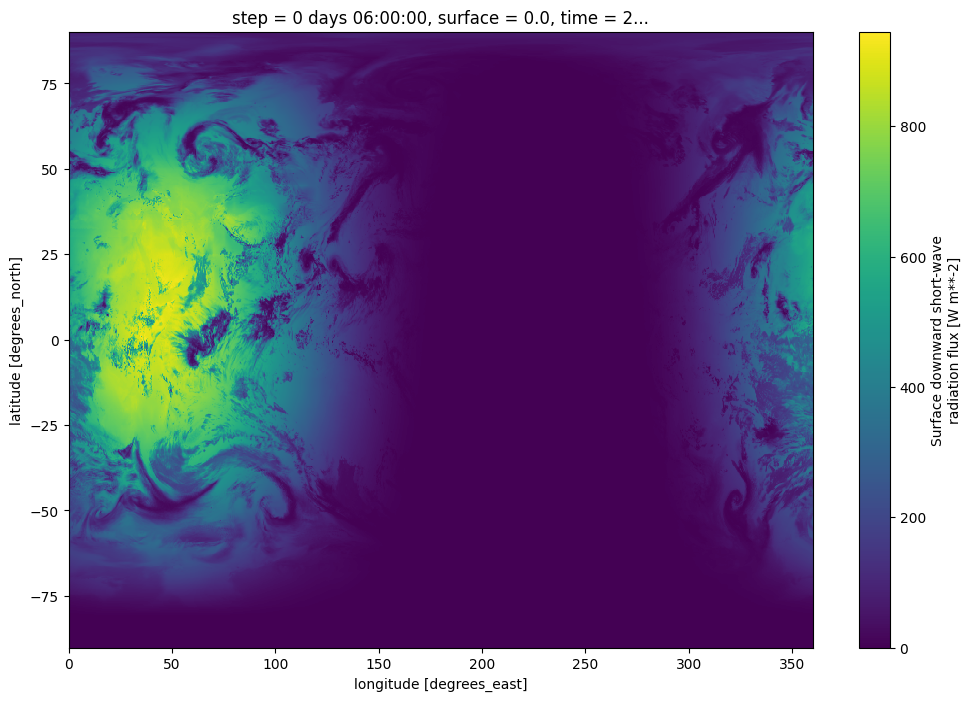

In [33]:
gfs_dt.sdswrf.avg.surface.sdswrf[0,1,:,:].plot(figsize=(12,8))

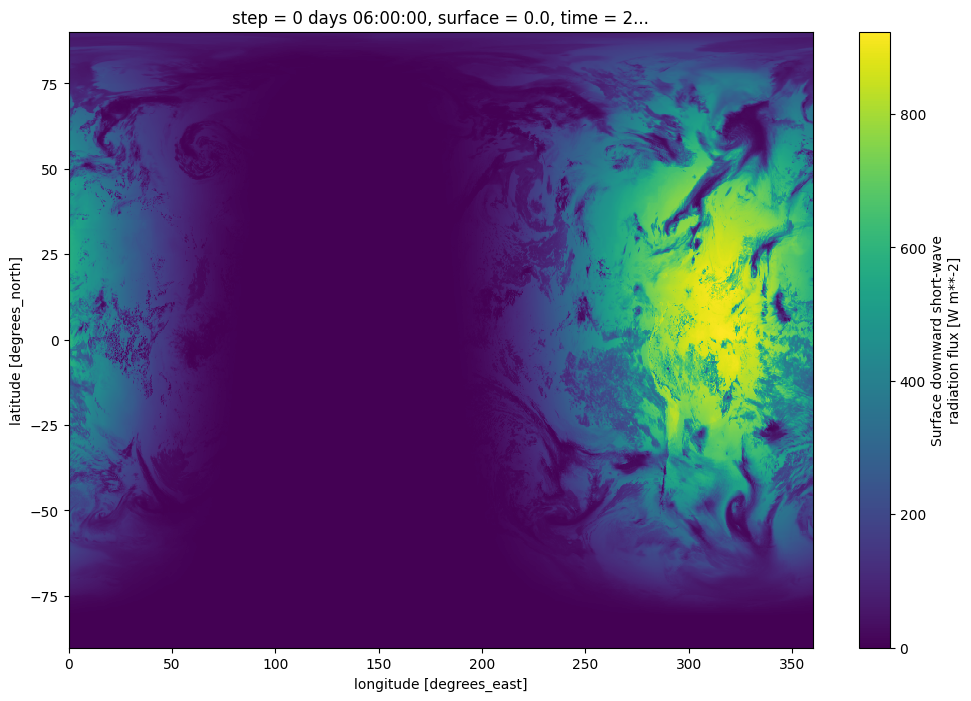

In [34]:
gfs_dt.sdswrf.avg.surface.sdswrf[0,2,:,:].plot(figsize=(12,8))

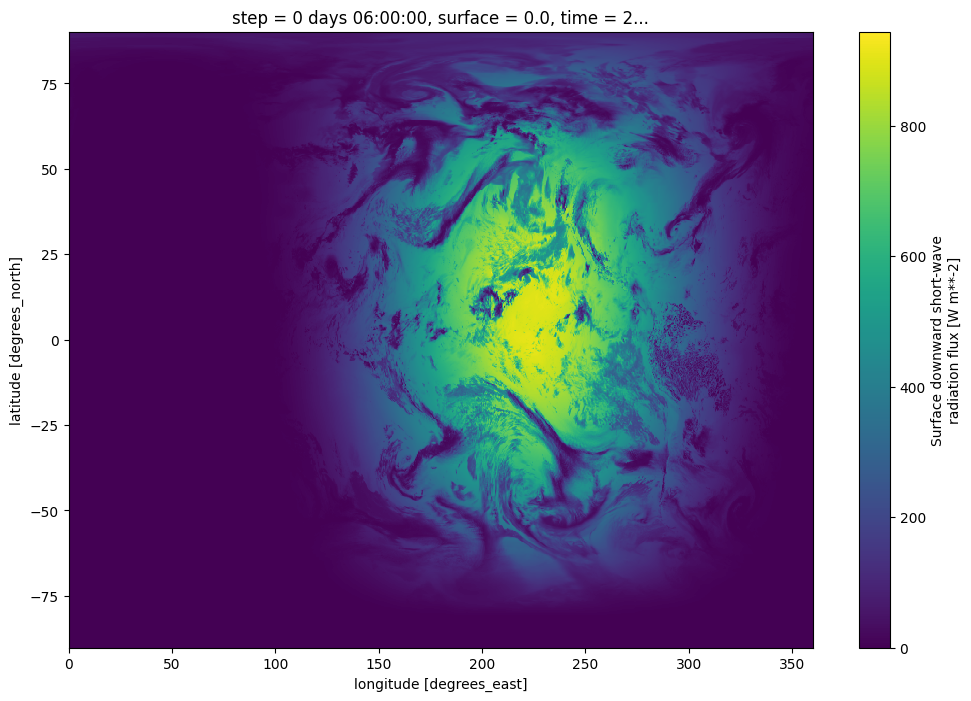

In [35]:
gfs_dt.sdswrf.avg.surface.sdswrf[0,3,:,:].plot(figsize=(12,8))

# Timeseries

In [36]:
# from joblib import parallel_config
# with parallel_config(n_jobs=8):
    #res = gfs_dt.dswrf.avg.surface.dswrf.interp(longitude=[320.5, 300.2], latitude=[20.6, 45.7], method="linear")
    


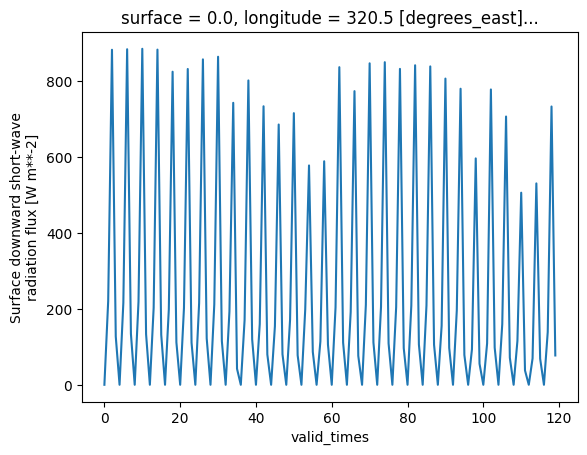

In [37]:
res = gfs_dt.sdswrf.avg.surface.sdswrf.interp(longitude=[320.5], latitude=[20.6], method="linear")
res.plot()
